# Intelligibilité

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.pipeline_creator import PipelineCreator
import product_sub.settings as stg

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN

import pdpbox

## Construction pipeline

In [2]:
dataset_merged = DatasetBuilder(
    filename_bank=stg.FILENAME_BANK, filename_socio=stg.FILENAME_SOCIO_ECO
).create_dataset()
X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=stg.RANDOM_STATE
)

custom_pipeline_accessor = PipelineCreator()
preprocessor = custom_pipeline_accessor.preprocessor

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
smt = SMOTEENN(sampling_strategy=1,random_state=stg.RANDOM_STATE, n_jobs=-1)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

## Construction graphique MDI

In [3]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# feature_importances

## DecisionTree Classifier

## RandomForest Classifier

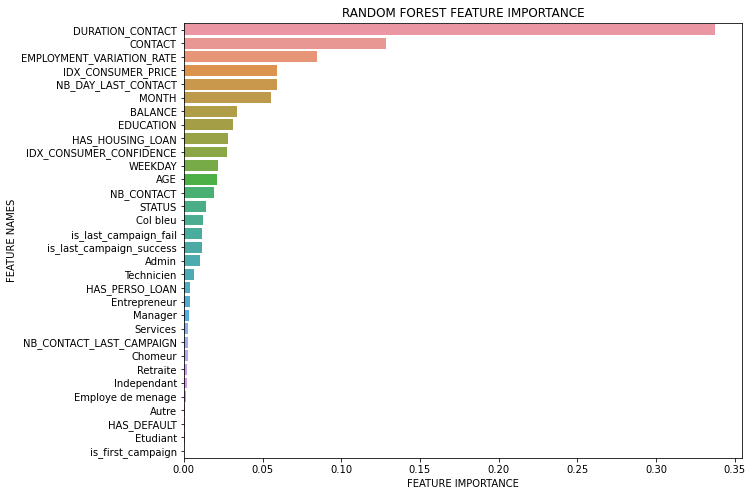

In [4]:
rf = RandomForestClassifier(criterion='gini', bootstrap=True, max_features='auto',
                                                    n_estimators=100, max_depth=None, min_samples_split=2, 
                                                    min_samples_leaf=1)

rff = rf.fit(X_resampled,y_resampled)
plot_feature_importance(rff[1].feature_importances_,stg.FINAL_COLUMNS,'RANDOM FOREST ')

## GradientBoosting Classifier

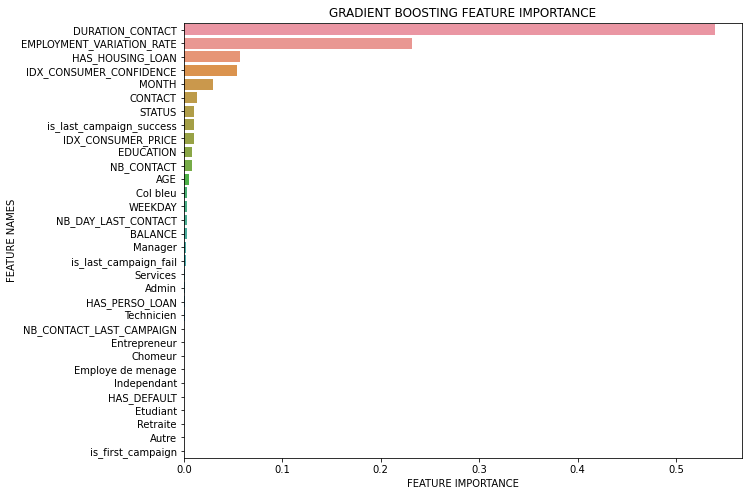

In [12]:
gbc =GradientBoostingClassifier(n_estimators=100, loss='deviance',learning_rate=0.1,
                                                         max_depth=5, random_state=stg.RANDOM_STATE)

gbc.fit(X_resampled,y_resampled)
plot_feature_importance(gbc.feature_importances_,stg.FINAL_COLUMNS,'GRADIENT BOOSTING ')

## Interprétation
- 2 features se dégagent ( DURATION_CONTACT et EMPLOYMENT_VARIATION_RATE ), nous allons donc les étudier par la suite

Création des DataFrames depuis les numpy array

In [16]:
X_train = pd.DataFrame(data= X_resampled, columns=stg.FINAL_COLUMNS)
X_test = pd.DataFrame(data= X_test, columns=stg.FINAL_COLUMNS)
f_predict = lambda x: gbc.predict_proba(x)[:, 1]

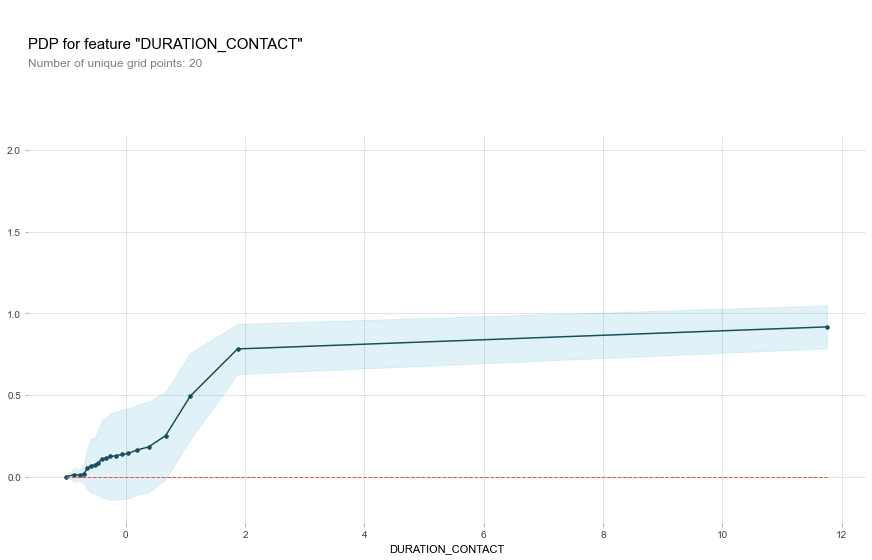

In [17]:
from pdpbox import pdp, info_plots
variable = 'DURATION_CONTACT' 

pdp_goals = pdp.pdp_isolate(model=gbc,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

La croissance de la durée de l'appel joue un rôle dans l'explication et la prédiction du modèle jusqu'à un seuil.

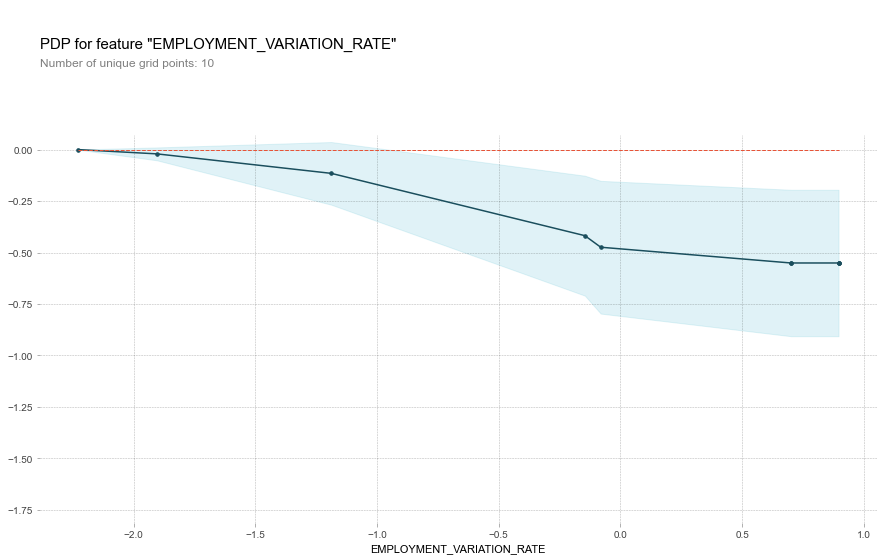

In [18]:
variable = stg.COL_RAW_EMPL_VAR_RATE
pdp_goals = pdp.pdp_isolate(model=gbc,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

Une augmentation du taux de la variation de l'emploi, implique un taux de chômage plus faible, et implique un taux de souscription plus faible

Text(0.5, 1.0, 'ICE Curves')

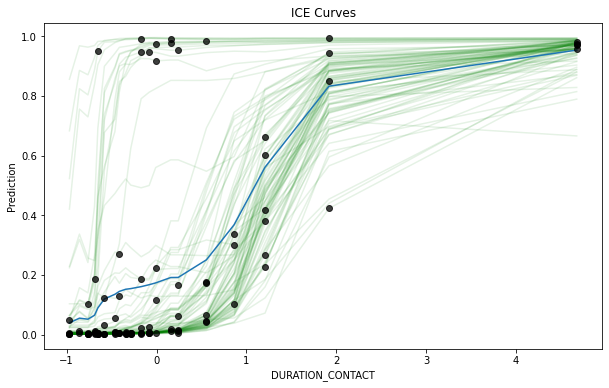

In [19]:
from pycebox.ice import ice, ice_plot
X_ref = X_test.copy().sample(100, random_state=42)
variable = 'DURATION_CONTACT' 

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')


Text(0.5, 1.0, 'ICE Curves')

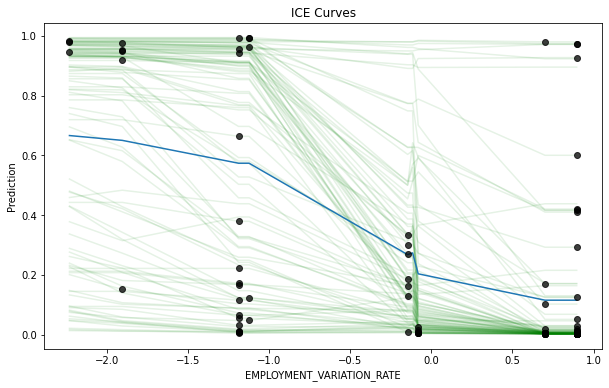

In [20]:
X_ref = X_test.copy().sample(100, random_state=42)
variable = stg.COL_RAW_EMPL_VAR_RATE

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')



In [21]:
import shap
shap.initjs()


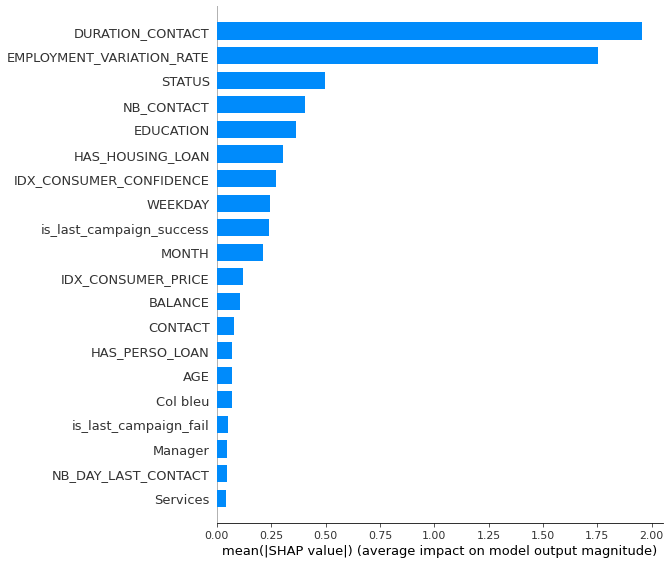

In [26]:
shap_values = shap.TreeExplainer(gbc).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Ce graphe confirme la feature importance calculée plus haut

In [46]:
X_ref_shap = X_test.copy().sample(2000, random_state=stg.RANDOM_STATE)

In [48]:
%%time
explanation = shap.TreeExplainer(gbc)
shap_values = explanation.shap_values(X_ref_shap)
shap.force_plot(explanation.expected_value, shap_values[99,:], X_ref.iloc[99,:])




CPU times: user 864 ms, sys: 5.71 ms, total: 870 ms
Wall time: 871 ms


In [45]:
explanation.expected_value

array([0.55166408])

In [38]:
shap.force_plot(explanation.expected_value, shap_values, X_ref_shap)

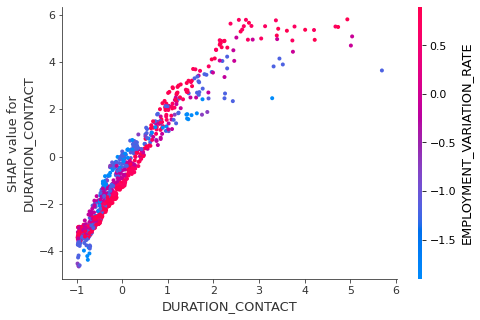

In [39]:
shap.dependence_plot(stg.COL_RAW_DURATION_CONTACT, shap_values, X_ref_shap)

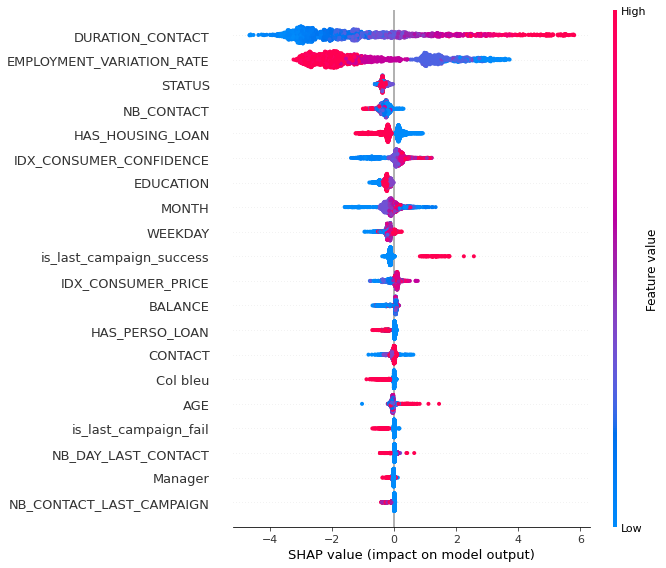

In [49]:
shap.summary_plot(shap_values, X_ref_shap, plot_type="dot")

- Grâce à ces graphes, on observe et confirme l'importance de la feature DURATION_CONTACT dans la prédiction de notre modèle ce qui était préssenti dans l'EDA.
- Ainsi, plus la durée de contact est élévée , plus les chances de voir le client souscrire au dépôt à terme est élévé. 